<a href="https://colab.research.google.com/github/indhu68/Intro_to_ML_HW7/blob/main/HW7_Q1_Intro_to_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                       Introduction to Machine Learning
                              Homework 7

Name : Indhuja Gudluru

Student ID : 801366046


In [2]:

!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.4 MB/s eta 0:00:00
time: 362 µs (started: 2023-12-13 10:02:47 +00:00)


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)


time: 10.9 s (started: 2023-12-13 10:02:47 +00:00)


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

time: 83.2 ms (started: 2023-12-13 10:03:03 +00:00)


In [5]:

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculating mean and standard(std)
images = torch.stack([img_t for img_t, _ in training_dataset], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:04<00:00, 39956555.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
time: 20.5 s (started: 2023-12-13 10:03:09 +00:00)


In [6]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 26.1 ms (started: 2023-12-13 10:03:29 +00:00)


In [7]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 3.66 ms (started: 2023-12-13 10:03:32 +00:00)


In [8]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 476 ms (started: 2023-12-13 10:03:36 +00:00)


In [9]:
cifar10_testing = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 356 ms (started: 2023-12-13 10:03:41 +00:00)


In [10]:

image1, label = cifar10[0]
print(image1.shape)

torch.Size([3, 32, 32])
time: 9.5 ms (started: 2023-12-13 10:03:45 +00:00)


In [11]:
training_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
testing_loader = DataLoader(cifar10_testing, batch_size=32, shuffle=False, num_workers=2)

time: 988 µs (started: 2023-12-13 10:03:47 +00:00)


In [12]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 476 µs (started: 2023-12-13 10:03:50 +00:00)


Problem : 1)a)

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

time: 1.66 ms (started: 2023-12-13 10:03:53 +00:00)


In [14]:

model = Net().to(device)

time: 5.91 s (started: 2023-12-13 10:03:55 +00:00)


In [15]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

time: 3.79 ms (started: 2023-12-13 10:04:04 +00:00)


In [16]:
import datetime

def training_loop(epochs, optimizer, model, loss_function, training_loader):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        for images, labels in training_loader:
            images = images.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, training_loss/ len(training_loader)))

time: 749 µs (started: 2023-12-13 10:04:07 +00:00)


In [19]:
training_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_function = nn.CrossEntropyLoss()

training_loop(
    epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_function = loss_function,
    training_loader = training_loader,
)


2023-12-13 10:05:22.507582 Epoch 1, Training loss 2.049105356111551
2023-12-13 10:05:37.057762 Epoch 2, Training loss 1.7751374871224699
2023-12-13 10:06:06.290883 Epoch 4, Training loss 1.5153167528264664
2023-12-13 10:06:35.153349 Epoch 6, Training loss 1.3847457374758123
2023-12-13 10:07:04.910032 Epoch 8, Training loss 1.263395033376601
2023-12-13 10:07:33.873916 Epoch 10, Training loss 1.179178176404875
2023-12-13 10:08:03.438858 Epoch 12, Training loss 1.121863442461204
2023-12-13 10:08:33.260479 Epoch 14, Training loss 1.0802870764756751
2023-12-13 10:09:02.518422 Epoch 16, Training loss 1.0482511693406897
2023-12-13 10:09:31.475054 Epoch 18, Training loss 1.0205531751408297
2023-12-13 10:10:02.095511 Epoch 20, Training loss 0.9982020632385293
2023-12-13 10:10:30.926245 Epoch 22, Training loss 0.9794200098575534
2023-12-13 10:11:00.788203 Epoch 24, Training loss 0.9626502136287787
2023-12-13 10:11:30.529825 Epoch 26, Training loss 0.9463696685593451
2023-12-13 10:11:59.778670 Ep

In [20]:

import collections
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_testing, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    predictions = []
    expected_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                expected_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict, predictions, expected_labels

time: 1.81 ms (started: 2023-12-13 11:19:04 +00:00)


In [21]:
accuracy, predictions, expected_labels = validate(model, training_loader, testing_loader)

Accuracy train: 0.81
Accuracy val: 0.61
time: 24.5 s (started: 2023-12-13 11:19:08 +00:00)


In [22]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.82      0.80      0.81      6155
  automobile       0.90      0.85      0.88      6338
        bird       0.70      0.68      0.69      6128
         cat       0.56      0.67      0.61      5014
        deer       0.73      0.74      0.74      5874
         dog       0.71      0.68      0.70      6269
        frog       0.83      0.82      0.82      6103
       horse       0.82      0.81      0.81      6023
        ship       0.87      0.84      0.86      6257
       truck       0.84      0.86      0.85      5839

    accuracy                           0.78     60000
   macro avg       0.78      0.78      0.78     60000
weighted avg       0.78      0.78      0.78     60000

time: 150 ms (started: 2023-12-13 11:19:44 +00:00)


In [23]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
confus_matrix = confusion_matrix(predictions, expected_labels)


time: 164 ms (started: 2023-12-13 11:19:49 +00:00)


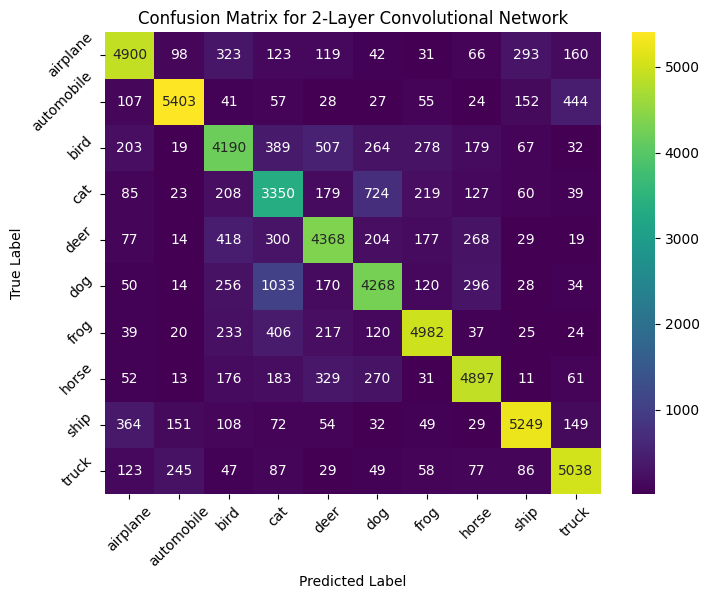

time: 513 ms (started: 2023-12-13 11:19:53 +00:00)


In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(confus_matrix, annot=True, cmap="viridis", fmt='g',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 2-Layer Convolutional Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()



Problem 1)b)

In [22]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 4 * 4, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = out.view(-1, 4 * 4 * 4)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out


time: 9.78 ms (started: 2023-12-13 04:31:17 +00:00)


In [23]:
model2 = Net2().to(device)

time: 4.19 ms (started: 2023-12-13 04:31:20 +00:00)


In [24]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

time: 11.9 ms (started: 2023-12-13 04:31:22 +00:00)


In [25]:
training_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model2 = Net2().to(device=device)
optimizer2 = optim.SGD(model2.parameters(), lr=1e-2)
loss_function = nn.CrossEntropyLoss()

training_loop(
    epochs = 300,
    optimizer = optimizer2,
    model = model2,
    loss_function = loss_function,
    training_loader = training_loader,
)

2023-12-13 04:31:44.770158 Epoch 1, Training loss 2.22520933081122
2023-12-13 04:32:03.233165 Epoch 2, Training loss 2.0232581310260023
2023-12-13 04:32:38.073532 Epoch 4, Training loss 1.7762009865792512
2023-12-13 04:33:15.627472 Epoch 6, Training loss 1.564370776076451
2023-12-13 04:33:50.333716 Epoch 8, Training loss 1.4571027211520984
2023-12-13 04:34:26.307014 Epoch 10, Training loss 1.384469603943398
2023-12-13 04:35:00.948289 Epoch 12, Training loss 1.3312959722088427
2023-12-13 04:35:36.851875 Epoch 14, Training loss 1.294299049907938
2023-12-13 04:36:11.850836 Epoch 16, Training loss 1.2623136932282801
2023-12-13 04:36:47.973269 Epoch 18, Training loss 1.2349525555167966
2023-12-13 04:37:22.645281 Epoch 20, Training loss 1.2109281624979376
2023-12-13 04:37:58.295561 Epoch 22, Training loss 1.1885659151217516
2023-12-13 04:38:32.884483 Epoch 24, Training loss 1.1705702875581239
2023-12-13 04:39:08.304631 Epoch 26, Training loss 1.1527944483872874
2023-12-13 04:39:43.861709 Epo